# Fitting epsilon 

We are going to have a go at fitting epsilon as a function of Teff to look at this from a statistical point of view. 

## Plotting the data 

17/12/24 10:14 George has uploaded the epsilon file to github inc uncertainty. 

In [80]:
import pandas as pd 

df = pd.read_csv('../Output/Epsilons.csv')
print(min(df.Epsilon))
df = df[df.Epsilon > 0.7]
df.Teff *= 1.0 
df.head()

0.6971831211064499


,ID,Epsilon,Epsilon_e,Teff,Teff_e
0,203530127,1.137346,0.023271,6212.0,45.0
1,211311380,1.108108,0.025576,6339.0,50.0
2,211401787,1.139524,0.023134,6336.0,53.0
3,211780967,0.941187,0.023293,6432.0,36.0
4,212026577,1.308745,0.007811,6118.0,43.0


In [88]:
np.log10(df.Teff.values)

array([3.79323145, 3.80202075, 3.80181517, 3.80834604, 3.78660947,
       3.75807882, 3.82118588, 3.79699039, 3.83186977, 3.79148012,
       3.7857568 , 3.77923563, 3.8076703 , 3.78901633, 3.81756537,
       3.78838052, 3.80590846, 3.79643556, 3.74429298, 3.77575604,
       3.8171024 , 3.77807886, 3.80773792, 3.80848106, 3.78146814,
       3.79719827, 3.77930783, 3.75258618, 3.78175537, 3.76350287,
       3.80434392, 3.81077001, 3.80386663, 3.77604707, 3.80379841,
       3.76185269, 3.79267179, 3.76230336, 3.80154091, 3.79028516,
       3.76417613, 3.80989625, 3.76700736, 3.75073975, 3.79358087,
       3.75617952, 3.76132632, 3.78418921, 3.7930916 , 3.74421472,
       3.77872992, 3.76297849, 3.77004155, 3.78031731, 3.79337125,
       3.78760215, 3.79747529, 3.79954731, 3.76260355, 3.78767296,
       3.78532984, 3.77662855, 3.8132473 , 3.79497574, 3.80597635,
       3.80379841, 3.79119925, 3.79169065, 3.8109714 , 3.80140371,
       3.79365072, 3.77437096, 3.7895102 , 3.82360463, 3.79961

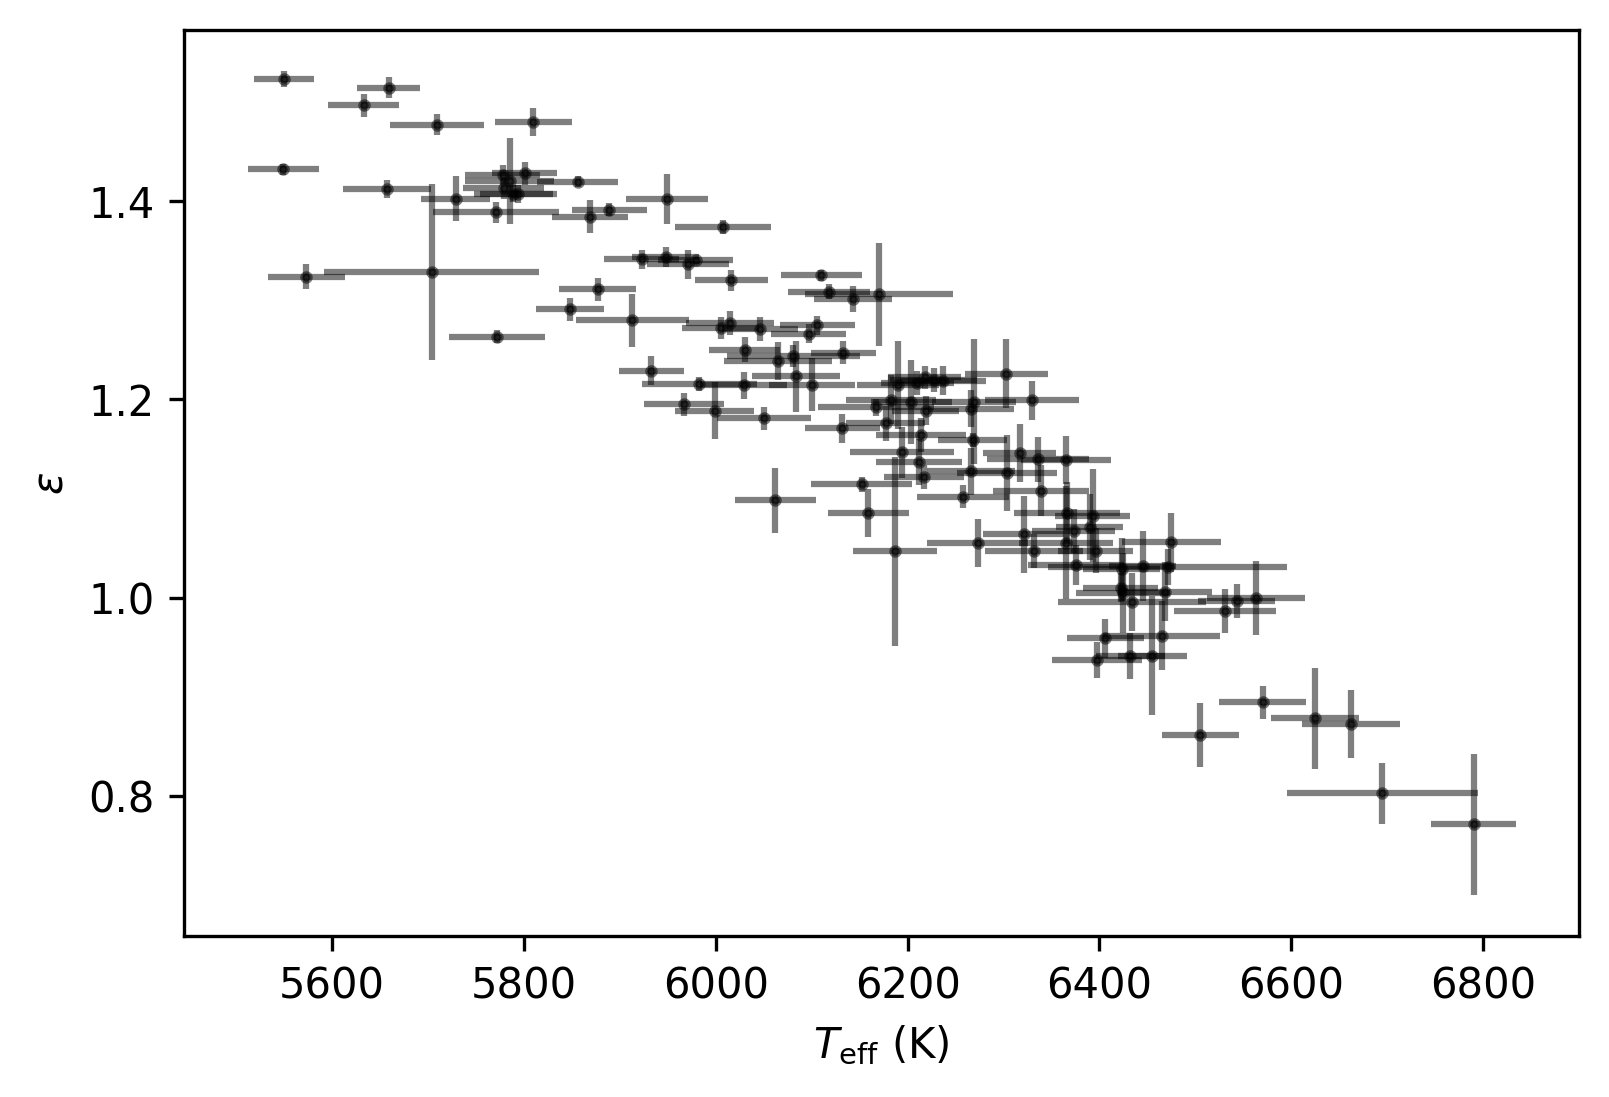

In [82]:
import matplotlib.pyplot as plt

def plot_data(df):

    fig, ax = plt.subplots(dpi=300)

    ax.scatter(df.Teff, df.Epsilon, c='k', alpha=0.5, s=4)
    ax.errorbar(df.Teff, df.Epsilon, 
                xerr = df.Teff_e,
                yerr = df.Epsilon_e,
                linestyle='none', c='k', alpha=0.5)

    ax.set_xlabel(r'$T_{\rm eff}$ (K)')
    ax.set_ylabel(r'$\epsilon$')
    
    return fig, ax 

fig, ax = plot_data(df)

## Fitting a really simple model

We always start simple and work up to the complicated stuff ... 

Order 1 z - [-7.87518731 31.02459085]
Order 2 z - [ -55.31646525  410.94693449 -761.72032785]
Order 3 z - [  135.82616099 -1598.18838799  6252.73836318 -8134.51139727]
Order 4 z - [   -4994.15875396    75787.89821671  -431335.44515806  1091166.19036551
 -1035230.11839409]


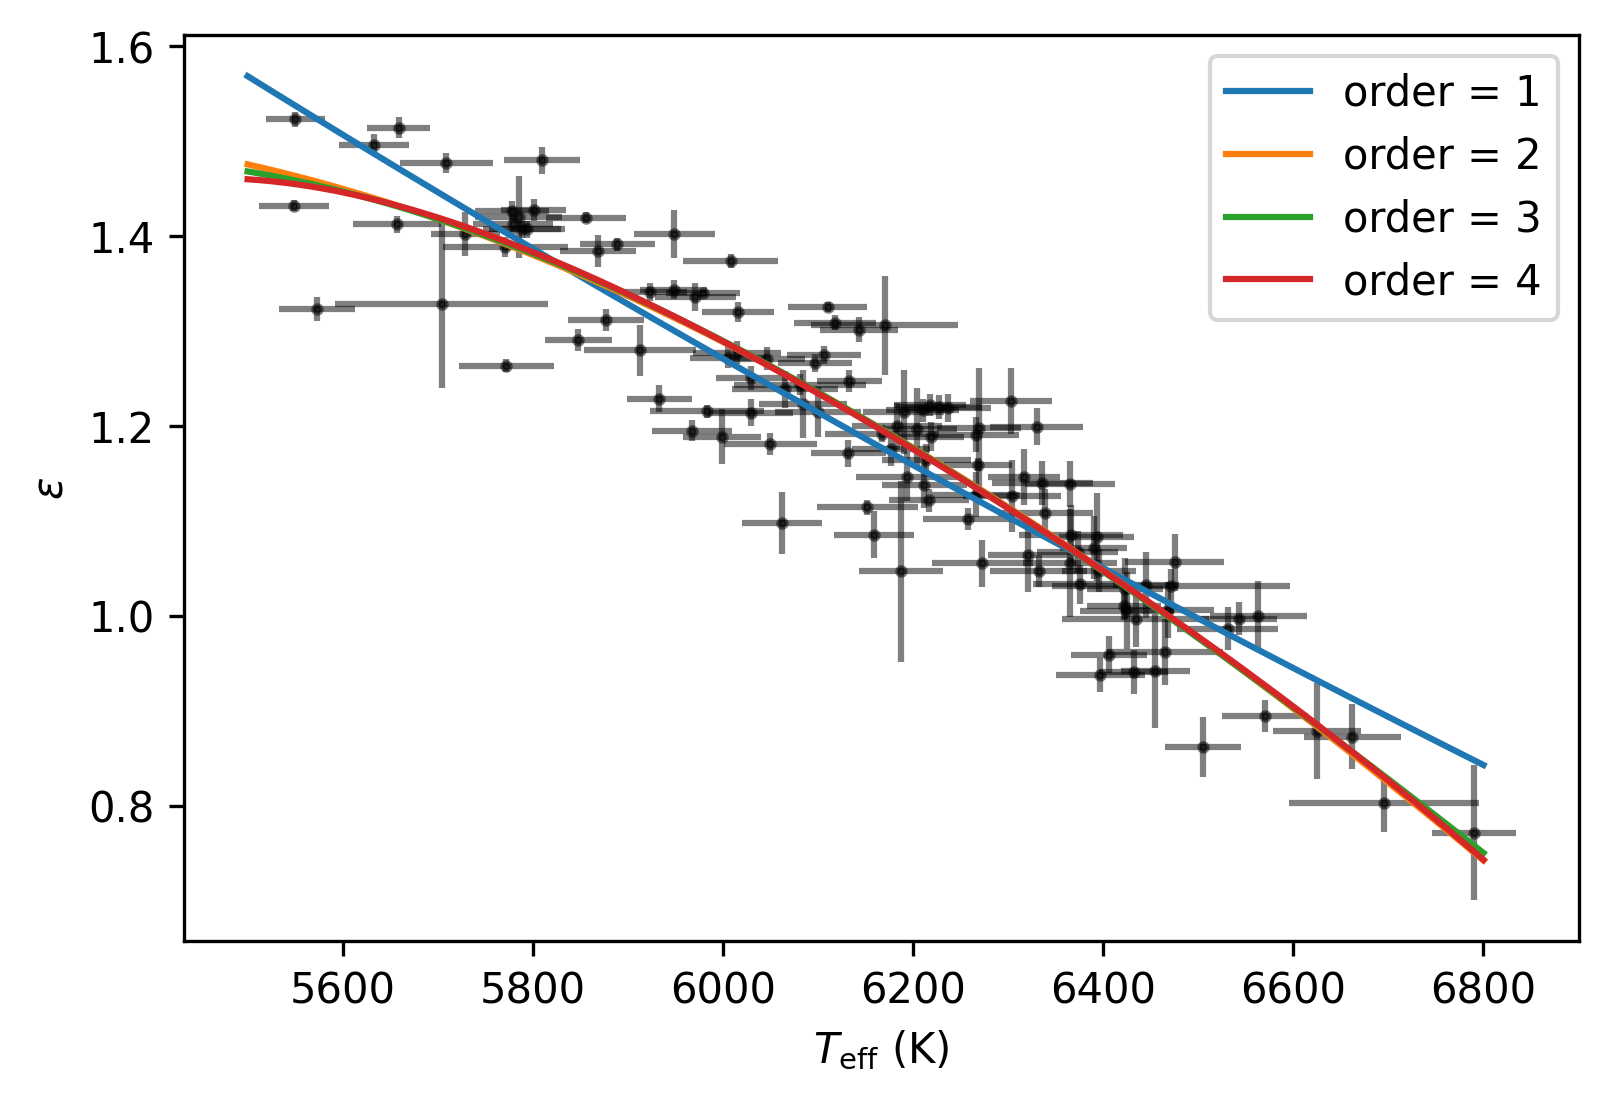

In [83]:
import numpy as np

order = [1, 2, 3, 4]
fig, ax = plot_data(df)
teff_range = np.linspace(5500, 6800, 100)

for o in order:
    z = np.polyfit(np.log10(df.Teff), df.Epsilon, o)
    p = np.poly1d(z)
    ax.plot(teff_range, p(np.log10(teff_range)), label=f'order = {o}')
    print(f'Order {o} z - {z}')

ax.legend()

Order = 2 looks like it will be more than good enough. 

## Let's actually start building a better model.

We will start by putting this all into numpyro and then worrying about the outlier and how we will treat these. 

In [117]:
import numpyro
import numpyro.distributions as dist

teff_mean = df.Teff.values
teff_unc = df.Teff_e.values

def model():
    x0 = numpyro.sample('x0', dist.Normal(0, 100))
    x1 = numpyro.sample('x1', dist.Normal(0, 100))
    x2 = numpyro.sample('x2', dist.Normal(0, 100))
    sigma = numpyro.sample('sigma', dist.Beta(2, 7))
    
    with numpyro.plate('stars', len(df)):
        Teff = numpyro.sample('Teff', dist.Normal(teff_mean, teff_unc))
        eps_pred = numpyro.sample('eps_pred', dist.Normal(x0 * (Teff/5777.0)**2 + (Teff/5777.0) * x1 + x2, sigma))
        obs = numpyro.sample('obs', dist.Normal(eps_pred, df.Epsilon_e.values), obs=df.Epsilon.values)

In [118]:
from jax import random, vmap
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=10000, num_samples=num_samples)
mcmc.run(
    rng_key_
)
mcmc.print_summary(exclude_deterministic=False)
samples_1 = mcmc.get_samples()

sample: 100%|█| 12000/12000 [01:05<00:00, 181.91it/s, 1023 steps of size 6.80e-0



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      Teff[0]   6225.72     39.99   6226.67   6166.84   6295.71     66.58      1.04
      Teff[1]   6337.85     41.29   6336.96   6266.98   6403.60     90.10      1.00
      Teff[2]   6306.25     48.05   6305.02   6225.97   6382.77     71.37      1.00
      Teff[3]   6450.26     35.12   6450.29   6396.63   6509.30     47.28      1.00
      Teff[4]   6088.74     41.35   6090.58   6016.09   6153.07     73.09      1.00
      Teff[5]   5727.46     35.18   5725.54   5674.19   5785.55     65.58      1.00
      Teff[6]   6633.59     38.55   6635.13   6572.32   6694.66     91.85      1.02
      Teff[7]   6254.19     41.45   6254.59   6186.42   6320.81     48.09      1.00
      Teff[8]   6786.55     37.73   6785.72   6724.67   6846.97     72.22      1.01
      Teff[9]   6199.14     43.32   6199.67   6126.94   6272.47     86.63      1.01
     Teff[10]   6093.51     35.96   6092.62   6035.10   6153.12     48.69  

<ErrorbarContainer object of 3 artists>

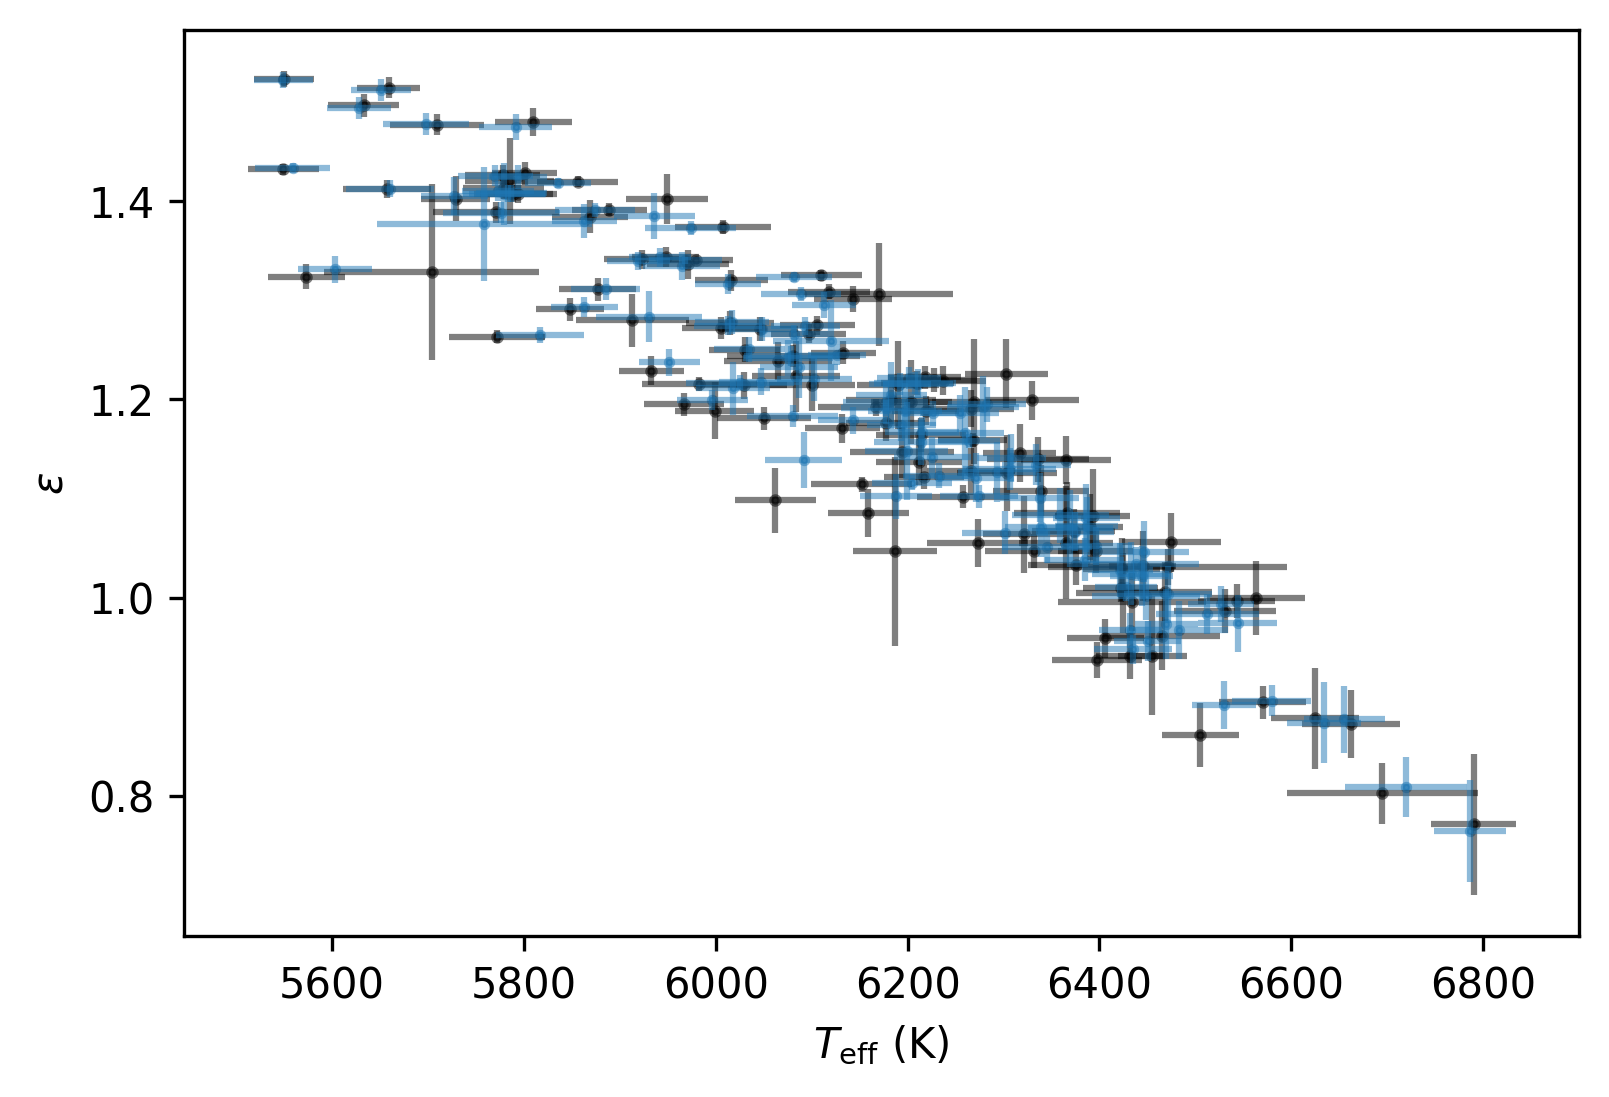

In [124]:
fig, ax = plot_data(df)

ax.scatter(samples_1['Teff'].mean(axis=0), samples_1['eps_pred'].mean(axis=0), 
           s=3, alpha=0.5)

ax.errorbar(samples_1['Teff'].mean(axis=0), samples_1['eps_pred'].mean(axis=0), 
           xerr=samples_1['Teff'].std(axis=0), 
           yerr=samples_1['eps_pred'].std(axis=0),
           linestyle='none', alpha=0.5)

Text(0, 0.5, 'Epsilon $T_{\\rm eff}$')

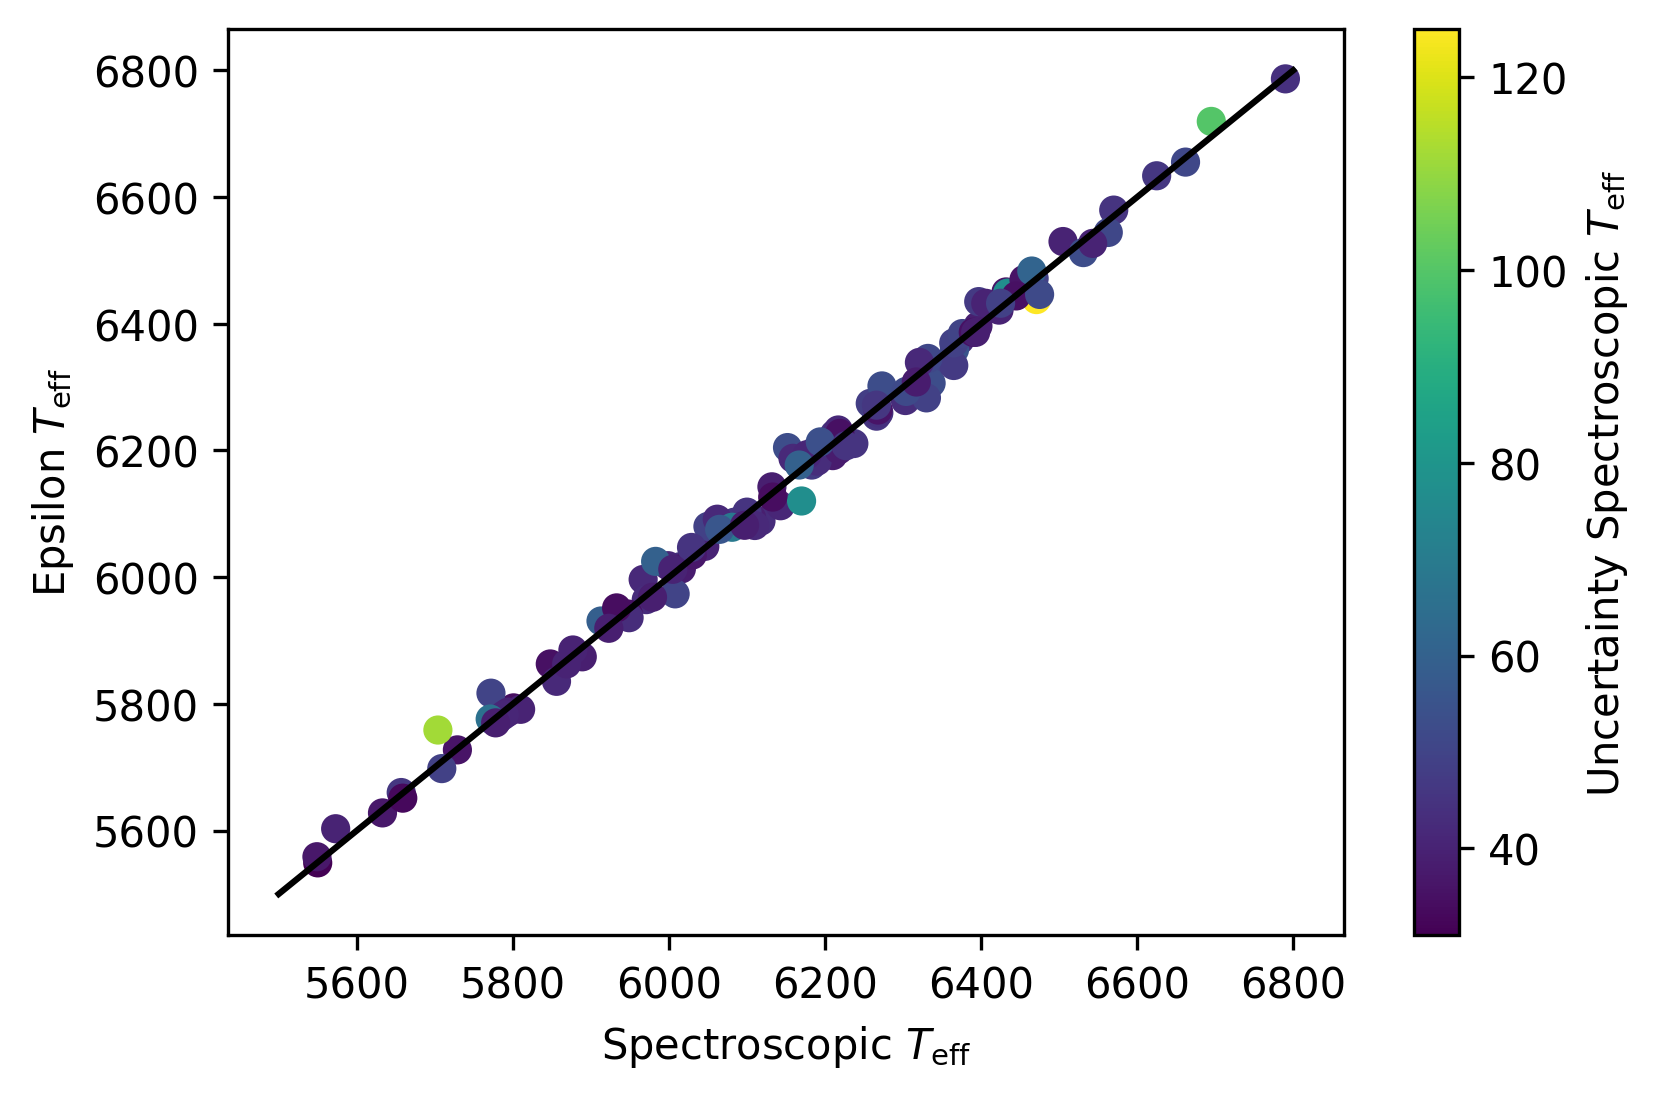

In [137]:
fig, ax = plt.subplots(dpi=300)

cs = ax.scatter(df.Teff, samples_1['Teff'].mean(axis=0), c=df.Teff_e)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Uncertainty Spectroscopic $T_{\rm eff}$')
t_ = np.linspace(5500, 6800, 10)
ax.plot(t_, t_, c='k')
ax.set_xlabel(r'Spectroscopic $T_{\rm eff}$')
ax.set_ylabel(r'Epsilon $T_{\rm eff}$')

Text(0, 0.5, 'Uncertainty Epsilon $T_{\\rm eff}$')

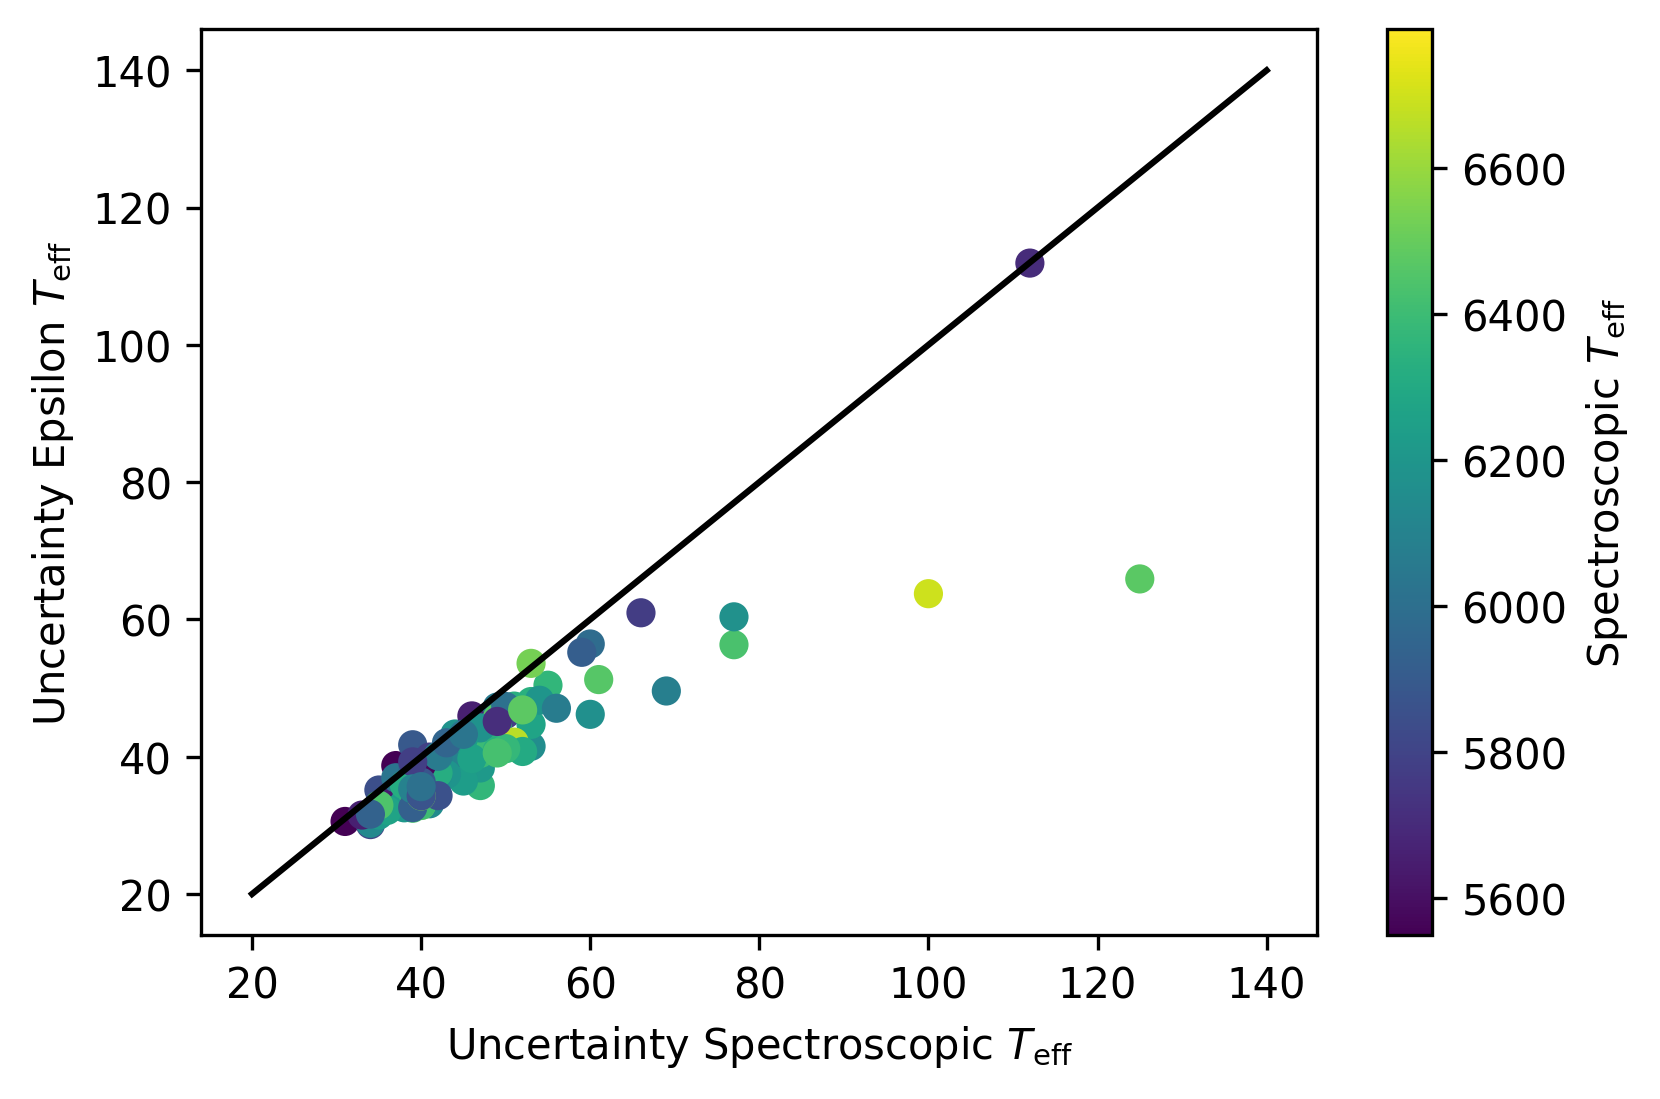

In [138]:
fig, ax = plt.subplots(dpi=300)

cs = ax.scatter(df.Teff_e, samples_1['Teff'].std(axis=0), c=df.Teff)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Spectroscopic $T_{\rm eff}$')
e_ = np.linspace(20, 140, 10)
ax.plot(e_, e_, c='k')
ax.set_xlabel(r'Uncertainty Spectroscopic $T_{\rm eff}$')
ax.set_ylabel(r'Uncertainty Epsilon $T_{\rm eff}$')